In [1]:
%matplotlib inline
import sys
sys.path.append("/home/mette/github/implicitmodules")


# Analyzing Differences Between Tree Images

Image registration with an implicit module of order 1. Segmentations given by the data are used to initialize its points.



## Initialization

Import relevant Python modules.




In [2]:
import time
import pickle
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import torch

import imodal


device = 'cuda:1'
torch.set_default_dtype(torch.float64)
imodal.Utilities.set_compute_backend('keops')

ModuleNotFoundError: No module named 'torchdiffeq'

Load source and target images, along with the source curve.




In [3]:
with open("/home/mette/github/implicitmodules/data/tree_growth.pickle", 'rb') as f:
    data = pickle.load(f)

source_shape = data['source_shape'].to(torch.get_default_dtype())
source_image = data['source_image'].to(torch.get_default_dtype())
target_image = data['target_image'].to(torch.get_default_dtype())

# Segmentations as Axis Aligned Bounding Boxes (AABB)
aabb_trunk = data['aabb_trunk']
aabb_crown = data['aabb_leaves']
extent = data['extent']

Display source and target images, along with the segmented source curve (orange
for the trunk, green for the crown).




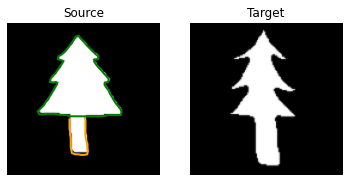

In [4]:
shape_is_trunk = aabb_trunk.is_inside(source_shape)
shape_is_crown = aabb_crown.is_inside(source_shape)

plt.subplot(1, 2, 1)
plt.title("Source")
plt.imshow(source_image, cmap='gray', origin='lower', extent=extent.totuple())
plt.plot(source_shape[shape_is_trunk, 0].numpy(), source_shape[shape_is_trunk, 1].numpy(), lw=2., color='orange')
plt.plot(source_shape[shape_is_crown, 0].numpy(), source_shape[shape_is_crown, 1].numpy(), lw=2., color='green')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Target")
plt.imshow(target_image, cmap='gray', origin='lower', extent=extent.totuple())
plt.axis('off')
plt.show()

Generating implicit modules of order 1 points and growth model tensor.




In [5]:
implicit1_density = 500.

# Lambda function defining the area in and around the tree shape
area = lambda x, **kwargs: imodal.Utilities.area_shape(x, **kwargs) | imodal.Utilities.area_polyline_outline(x, **kwargs)
polyline_width = 0.07

# Generation of the points of the initial geometrical descriptor
implicit1_points = imodal.Utilities.fill_area_uniform_density(area, imodal.Utilities.AABB(xmin=0., xmax=1., ymin=0., ymax=1.), implicit1_density, shape=source_shape, polyline=source_shape, width=polyline_width)

# Masks that flag points into either the trunk or the crown
implicit1_trunk_points = aabb_trunk.is_inside(implicit1_points)
implicit1_crown_points = aabb_crown.is_inside(implicit1_points)

implicit1_points = implicit1_points[implicit1_trunk_points | implicit1_crown_points]
implicit1_trunk_points = aabb_trunk.is_inside(implicit1_points)
implicit1_crown_points = aabb_crown.is_inside(implicit1_points)

assert implicit1_points[implicit1_trunk_points].shape[0] + implicit1_points[implicit1_crown_points].shape[0] == implicit1_points.shape[0]

# Initial normal frames
implicit1_r = torch.eye(2).repeat(implicit1_points.shape[0], 1, 1)

# Growth model tensor
implicit1_c = torch.zeros(implicit1_points.shape[0], 2, 4)

# Horizontal stretching for the trunk
implicit1_c[implicit1_trunk_points, 0, 0] = 1.
# Vertical stretching for the trunk
implicit1_c[implicit1_trunk_points, 1, 1] = 1.
# Horizontal stretching for the crown
implicit1_c[implicit1_crown_points, 0, 2] = 1.
# Vertical stretching for the crown
implicit1_c[implicit1_crown_points, 1, 3] = 1.

Plot the 4 dimensional growth model tensor.




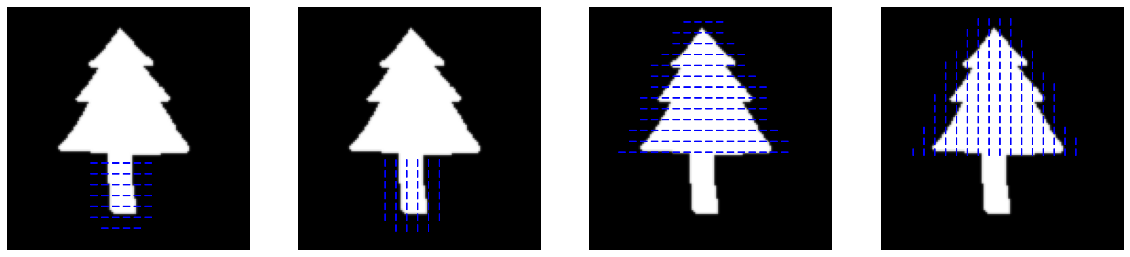

In [6]:
plt.figure(figsize=[20., 5.])
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(source_image, origin='lower', extent=extent, cmap='gray')
    imodal.Utilities.plot_C_ellipses(ax, implicit1_points, implicit1_c, c_index=i, color='blue', scale=0.03)
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.axis('off')

plt.show()

Create the deformation model with a combination of 2 modules : a global translation and the implicit module of order 1.




Create and initialize the global translation module **global_translation**.




In [7]:
global_translation_coeff = 1.
global_translation = imodal.DeformationModules.GlobalTranslation(2, coeff=global_translation_coeff)

Create and initialize the implicit module of order 1 **implicit1**.




In [8]:
sigma1 = 2./implicit1_density**(1/2)
implicit1_coeff = 0.1
implicit1_nu = 100.
implicit1 = imodal.DeformationModules.ImplicitModule1(2, implicit1_points.shape[0], sigma1, implicit1_c, nu=implicit1_nu, gd=(implicit1_points, implicit1_r), coeff=implicit1_coeff)
implicit1.eps = 1e-2

Define deformables used by the registration model.




In [9]:
source_image_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent=extent)
target_image_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent=extent)

source_image_deformable.to_device(device)
target_image_deformable.to_device(device)

/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/torch/cuda/__init__.py:104: UserWarning: 
GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70 sm_75.
If you want to use the GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


## Registration
Define the registration model.




In [10]:
attachment_image = imodal.Attachment.L2NormAttachment(weight=1e0)

model = imodal.Models.RegistrationModel([source_image_deformable], [implicit1, global_translation], [attachment_image], lam=1.)
model.to_device(device)

Fitting using Torch LBFGS optimizer.




In [11]:
shoot_solver = 'rk4'
shoot_it = 10

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')
fitter.fit([target_image_deformable], 500, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe', 'history_size': 500})

[pyKeOps] Compiling libKeOpstorch6b45708165 in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction(TensorProd(-S*Exp(-S*SqNorm2(x - y)/IntCst(2))*(x - y), p),0)
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,2); S = Pm(3,1); 
       dtype  : float64
... 


/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Done.
[pyKeOps] Compiling libKeOpstorchf9a7f9d659 in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction(TensorDot(-S*Exp(-S*SqNorm2(x - y)/IntCst(2))*(S*TensorDot(x-y, x-y, Ind(2), Ind(2), Ind(), Ind())-eye), p, Ind(2, 2), Ind(2, 2), Ind(1),Ind(1)),0)
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,4); eye = Pm(3,4); S = Pm(4,1); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorch872ec3ebb2 in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction(TensorDot(TensorDot((-S*Exp(-S*SqNorm2(x_i - y_j)*IntInv(2))*(S*TensorDot(x_i - y_j, x_i - y_j, Ind(2), Ind(2), Ind(), Ind()) - eye)), A, Ind(2, 2), Ind(2, 2, 3, 3), Ind(0, 1), Ind(0, 1)), X, Ind(3, 3), Ind(3), Ind(0), Ind(0)),0)
       aliases: x_i = Vi(0,2); y_j = Vj(1,2); X = Vj(2,3); eye = Pm(3,4); S = Pm(4,1); A = Pm(5,36); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorch9cad040fff in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction(

/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


[pyKeOps] Compiling libKeOpstorchfdf885ae93 in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(TensorProd(-S*Exp(-S*SqNorm2(x - y)/IntCst(2))*(x - y), p),0), Var(2,2,1), Var(4,4,0), Var(5,4,0)), Var(0,2,0), Var(6,2,1), Var(7,2,1))
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,2); S = Pm(3,1); Var(4,4,0); Var(5,4,0); Var(6,2,1); Var(7,2,1); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorchb27ec13fe1 in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(TensorProd(-S*Exp(-S*SqNorm2(x - y)/IntCst(2))*(x - y), p),0), Var(2,2,1), Var(4,4,0), Var(5,4,0)), Var(1,2,1), Var(6,2,1), Var(7,2,1))
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,2); S = Pm(3,1); Var(4,4,0); Var(5,4,0); Var(6,2,1); Var(7,2,1); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorcha973a3ae2b in /home/mette/.cache/pykeops-1.5-cpython-38:
      

Done.
[pyKeOps] Compiling libKeOpstorchde975f3798 in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(TensorDot(-S*Exp(-S*SqNorm2(x - y)/IntCst(2))*(S*TensorDot(x-y, x-y, Ind(2), Ind(2), Ind(), Ind())-eye), p, Ind(2, 2), Ind(2, 2), Ind(1),Ind(1)),0), Var(1,2,1), Var(5,4,0), Var(6,4,0)), Var(2,4,1), Var(7,2,1), Var(8,2,1))
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,4); eye = Pm(3,4); S = Pm(4,1); Var(5,4,0); Var(6,4,0); Var(7,2,1); Var(8,2,1); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorch15451b1ff4 in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(TensorDot(-S*Exp(-S*SqNorm2(x - y)/IntCst(2))*(S*TensorDot(x-y, x-y, Ind(2), Ind(2), Ind(), Ind())-eye), p, Ind(2, 2), Ind(2, 2), Ind(1),Ind(1)),0), Var(1,2,1), Var(5,4,0), Var(6,4,0)), Var(5,4,0), Var(7,2,1), Var(8,2,1))
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,4); 

Done.
[pyKeOps] Compiling libKeOpstorch9c450425c7 in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(TensorDot(TensorDot((-S*Exp(-S*SqNorm2(x_i - y_j)*IntInv(2))*(S*TensorDot(x_i - y_j, x_i - y_j, Ind(2), Ind(2), Ind(), Ind()) - eye)), A, Ind(2, 2), Ind(2, 2, 3, 3), Ind(0, 1), Ind(0, 1)), X, Ind(3, 3), Ind(3), Ind(0), Ind(0)),0), Var(0,2,0), Var(6,3,0), Var(7,3,0)), Var(6,3,0), Var(8,2,0), Var(9,2,0))
       aliases: x_i = Vi(0,2); y_j = Vj(1,2); X = Vj(2,3); eye = Pm(3,4); S = Pm(4,1); A = Pm(5,36); Var(6,3,0); Var(7,3,0); Var(8,2,0); Var(9,2,0); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorcha87ac36d4d in /home/mette/.cache/pykeops-1.5-cpython-38:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(TensorDot(TensorDot((-S*Exp(-S*SqNorm2(x_i - y_j)*IntInv(2))*(S*TensorDot(x_i - y_j, x_i - y_j, Ind(2), Ind(2), Ind(), Ind()) - eye)), A, Ind(2, 2), Ind(2, 2, 3, 3), Ind(0, 1), 

/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Evaluated model with costs=76225141.99999996
Evaluated model with costs=170925619.2474139
Evaluated model with costs=139431230.22758004
Evaluated model with costs=77996042.62989637
Evaluated model with costs=73561658.93530643
Evaluated model with costs=71255291.67314844
Evaluated model with costs=72692010.87480694
Evaluated model with costs=68180920.64196096
Evaluated model with costs=64229943.1123947
Evaluated model with costs=123733567.03527786
Evaluated model with costs=64647741.01900619
Evaluated model with costs=53346260.05323863
Evaluated model with costs=52755677.88530066
Evaluated model with costs=51962364.741079055
Evaluated model with costs=51568446.05569796
Evaluated model with costs=51695310.64918505
Evaluated model with costs=51546673.90358839
Evaluated model with costs=51482965.013065636
Evaluated model with costs=52517250.53454388
Evaluated model with costs=51470974.04351078
Evaluated model with costs=51434972.366057254
Evaluated model with costs=51404680.97302379
Evalua

## Visualization
Compute optimized deformation trajectory.




In [12]:
deformed_intermediates = {}
start = time.perf_counter()
with torch.autograd.no_grad():
    deformed_image = model.compute_deformed(shoot_solver, shoot_it, intermediates=deformed_intermediates)[0][0].detach().cpu()
print("Elapsed={elapsed}".format(elapsed=time.perf_counter()-start))

Elapsed=36.3842728480231


Display deformed source image and target.




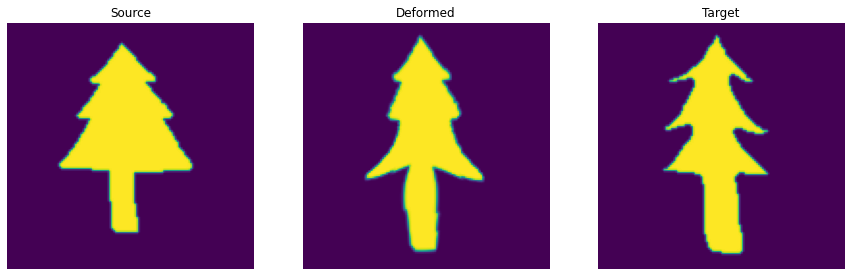

In [13]:
plt.figure(figsize=[15., 5.])
plt.subplot(1, 3, 1)
plt.title("Source")
plt.imshow(source_image, extent=extent.totuple(), origin='lower')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Deformed")
plt.imshow(deformed_image, extent=extent.totuple(), origin='lower')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target")
plt.imshow(target_image, extent=extent.totuple(), origin='lower')
plt.axis('off')

plt.show()

We can follow the action of each part of the total deformation by setting all the controls components to zero but one.




Functions generating controls to follow one part of the deformation.




In [14]:
def generate_implicit1_controls(table):
    outcontrols = []
    for control in deformed_intermediates['controls']:
        outcontrols.append(control[1]*torch.tensor(table, dtype=torch.get_default_dtype(), device=device))

    return outcontrols


def generate_controls(implicit1_table, trans):
    outcontrols = []
    implicit1_controls = generate_implicit1_controls(implicit1_table)
    for control, implicit1_control in zip(deformed_intermediates['controls'], implicit1_controls):
        outcontrols.append([implicit1_control, control[2]*torch.tensor(trans, dtype=torch.get_default_dtype(), device=device)])

    return outcontrols

Function to compute a deformation given a set of controls up to some time point.




In [15]:
grid_resolution = [16, 16]


def compute_intermediate_deformed(it, controls, t1, intermediates=None):
    implicit1_points = deformed_intermediates['states'][0][1].gd[0]
    implicit1_r = deformed_intermediates['states'][0][1].gd[1]
    implicit1_cotan_points = deformed_intermediates['states'][0][1].cotan[0]
    implicit1_cotan_r = deformed_intermediates['states'][0][1].cotan[1]
    silent_cotan = deformed_intermediates['states'][0][0].cotan

    implicit1 = imodal.DeformationModules.ImplicitModule1(2, implicit1_points.shape[0], sigma1, implicit1_c.clone(), nu=implicit1_nu, gd=(implicit1_points.clone(), implicit1_r.clone()), cotan=(implicit1_cotan_points, implicit1_cotan_r), coeff=implicit1_coeff)
    global_translation = imodal.DeformationModules.GlobalTranslation(2, coeff=global_translation_coeff)

    implicit1.to_(device=device)
    global_translation.to_(device=device)

    source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent=extent)
    source_deformable.silent_module.manifold.cotan = silent_cotan

    grid_deformable = imodal.Models.DeformableGrid(extent, grid_resolution)

    source_deformable.to_device(device)
    grid_deformable.to_device(device)

    costs = {}
    with torch.autograd.no_grad():
        deformed = imodal.Models.deformables_compute_deformed([source_deformable, grid_deformable], [implicit1, global_translation], shoot_solver, it, controls=controls, t1=t1, intermediates=intermediates, costs=costs)

    return deformed[0][0]

Functions to generate the deformation trajectory given a set of controls.




In [16]:
def generate_images(table, trans, outputfilename):
    incontrols = generate_controls(table, trans)
    intermediates_shape = {}
    deformed = compute_intermediate_deformed(10, incontrols, 1., intermediates=intermediates_shape)

    trajectory_grid = [imodal.Utilities.vec2grid(state[1].gd, grid_resolution[0], grid_resolution[1]) for state in intermediates_shape['states']]

    trajectory = [source_image]
    t = torch.linspace(0., 1., 11)
    indices = [0, 3, 7, 10]
    print("Computing trajectories...")
    for index in indices[1:]:
        print("{}, t={}".format(index, t[index]))
        deformed = compute_intermediate_deformed(index, incontrols[:4*index], t[index])

        trajectory.append(deformed)

    print("Generating images...")
    plt.figure(figsize=[5.*len(indices), 5.])
    for deformed, i in zip(trajectory, range(len(indices))):
        ax = plt.subplot(1, len(indices), i + 1)

        grid = trajectory_grid[indices[i]]
        plt.imshow(deformed.cpu(), origin='lower', extent=extent, cmap='gray')
        imodal.Utilities.plot_grid(ax, grid[0].cpu(), grid[1].cpu(), color='xkcd:light blue', lw=1)
        plt.xlim(0., 1.)
        plt.ylim(0., 1.)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Generate trajectory of the total optimized deformation.




Computing trajectories...
3, t=0.30000000000000004
7, t=0.7000000000000001
10, t=1.0
Generating images...


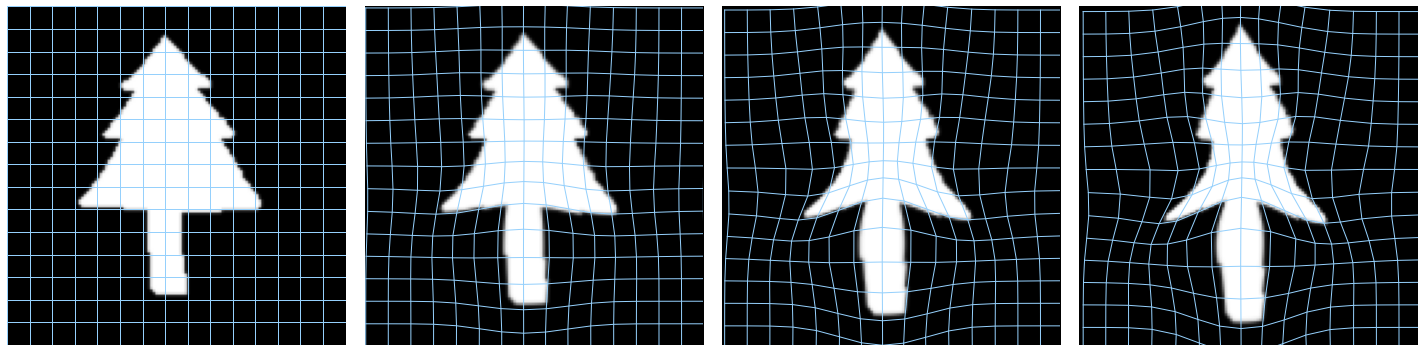

In [17]:
generate_images([True, True, True, True], True, "deformed_all")

Generate trajectory following vertical elongation of the trunk.




/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Computing trajectories...
3, t=0.30000000000000004
7, t=0.7000000000000001
10, t=1.0
Generating images...


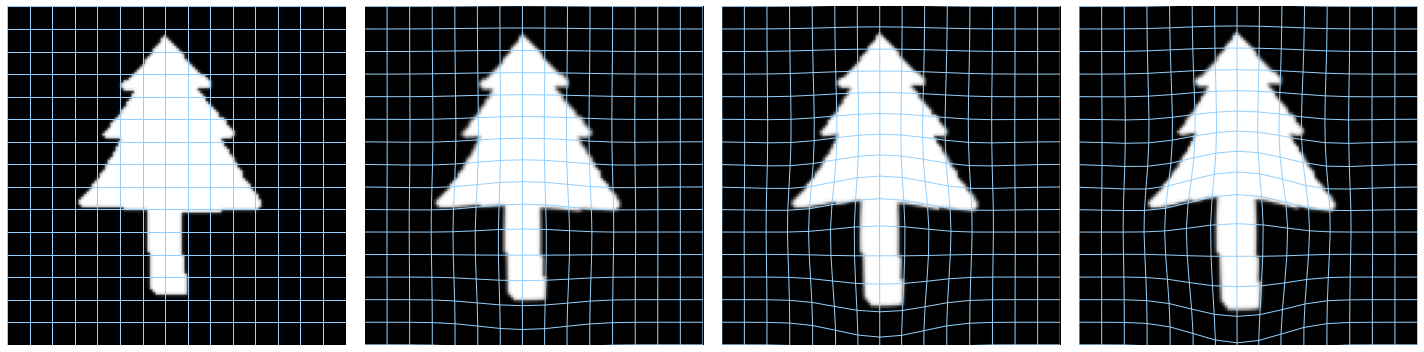

In [18]:
generate_images([False, True, False, False], False, "deformed_trunk_vertical")

Generate trajectory following horizontal elongation of the crown.




/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Computing trajectories...
3, t=0.30000000000000004
7, t=0.7000000000000001
10, t=1.0
Generating images...


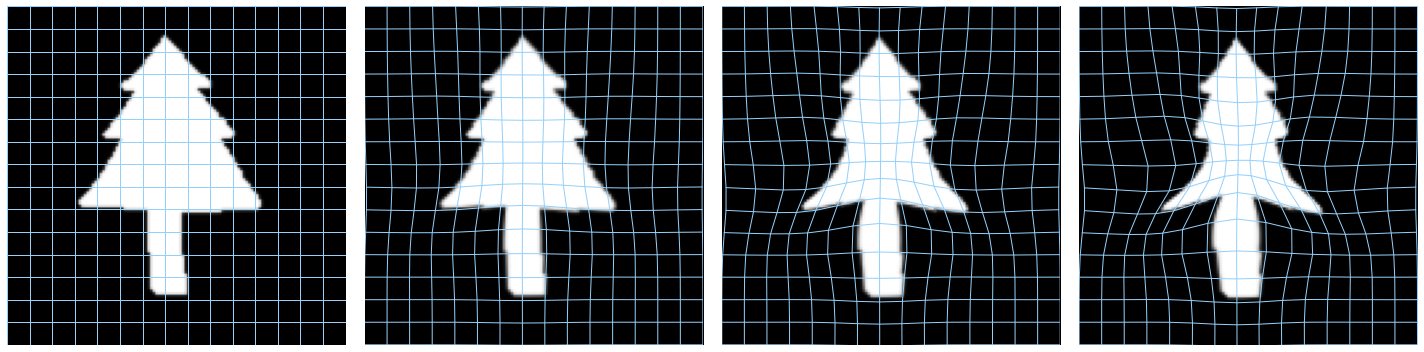

In [19]:
generate_images([False, False, True, False], False, "deformed_crown_horizontal")